In [1]:
## Install dependensies
!pip install -q diffusers=='0.12.1'
!pip install -q transformers
!pip install -q accelerate
!pip install -q gradio
!pip install pyrallis

fatal: destination path 'semantic-ddm-official-beta' already exists and is not an empty directory.
/content/semantic-ddm-official-beta


# PCA

[Warning] Scheduler assumes clipping, setting to false
[INFO] Loaded from results/pca/pca-google-ddpm-ema-celebahq-256steps10-hspace-after-samples-500-etas-1-raw.pt


10it [00:12,  1.21s/it]


[INFO] SIGN Ambiguity: changed sign on 94 vectors
[INFO] SIGN Ambiguity: changed sign on 94 vectors
[INFO] SIGN Ambiguity: changed sign on 94 vectors


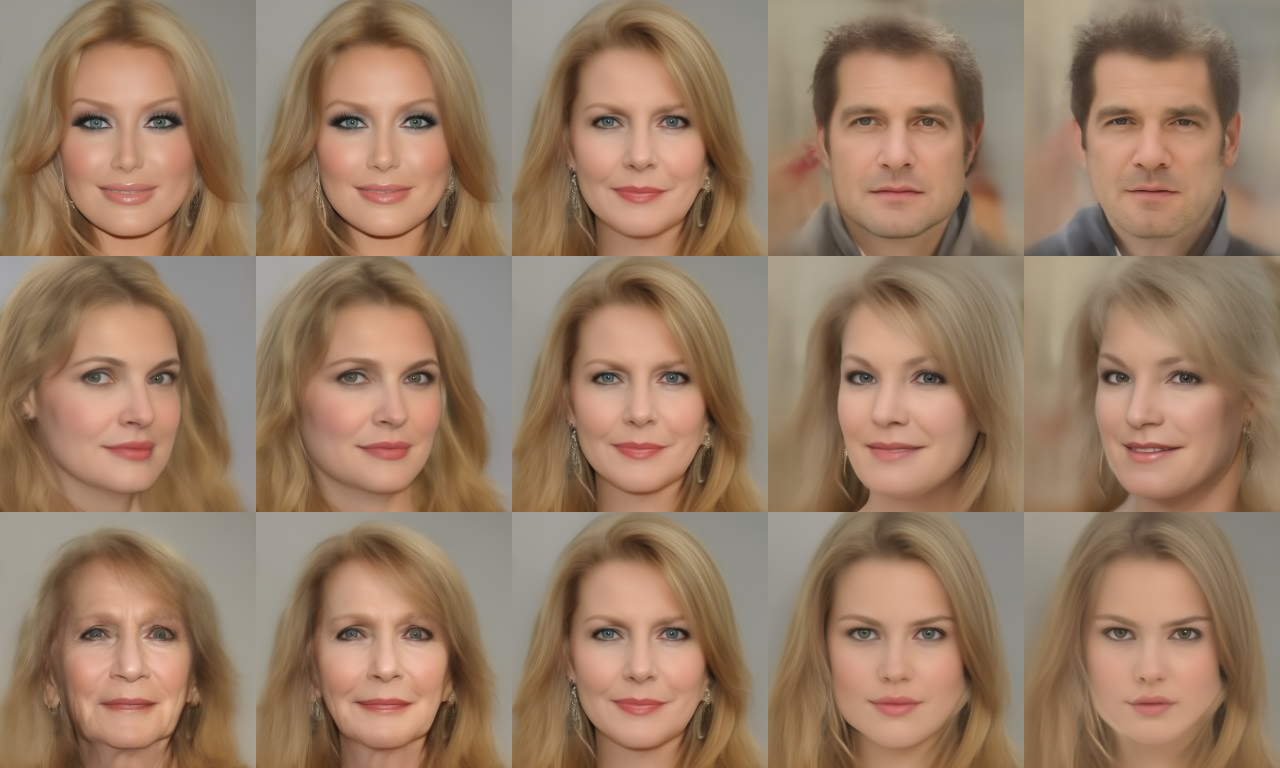

In [33]:
from semanticdiffusion import load_model, Q
from editing.pca import PCAMethod
from editing.direction_plotter import DirectionPlotter
from utils import image_grid
import torch

torch.manual_seed(42)

sd = load_model("pixel", device = "cuda",
                h_space = "after",
                num_inference_steps = 10)

pca = PCAMethod(sd)
dp = DirectionPlotter(sd)
hhs = pca.sample(num_samples=500, etas = 1, force_rerun=False)
PCs, ss, Uts = pca.get_PCs_indv(hhs)

q = sd.sample(seed = 84, etas = 1)
q_edits = []
for eig_idx in [0,1,3]:
    n = dp.get_direction(Uts, ss, svec_idx = eig_idx)
    q_edits += [sd.apply_direction(q.copy(),n, scale = scale) for scale in torch.linspace(-5,5,5)]
imgs = [q.x0 for q in q_edits]
grid = image_grid(imgs, cols = 5, rows = 3)
grid.save("docs/resources/pca.png")
grid



## Supervised

In [ ]:
from semanticdiffusion import load_model, Q
from editing.anycost import AnycostDirections
from utils import image_grid

sd = load_model("pixel", # Model to load, supports "pixel"/"lsm" or checkpoint path to HuggingFace models
                device = "cuda",
                h_space = "after", # Is the sementic latent space defined as ["before", middle","after"] the middle convolution in the U-net
                num_inference_steps = 10,
                )

ad = AnycostDirections(sd, etas = None,    # Noise schedule. None/0 for DDIM, 1 for DDPM. List if eta_t values is also supported
                       idx_size = 100,     # Size of index. The number of images sampled in total
                        num_examples = 10, # Choose num_examples top(bottom), positive(negative) examples for a given attribute from the sampled images
                        )

q_original = sd.sample(seed = 76) # All information about a sample is contained in the Q object
img_original = sd.show(q_original) # Easy decoding and conversion to PIL.Image

# Edit Age
label = "Young" #Eg. "Smiling", "Eyeglasses", "Young", "Male" (see full list in editing/anycost.py)
n = ad.get_direction(label)
q_edit = sd.apply_direction(q_original.copy(), n, scale = -0.6)
img_edit_age = sd.show(q_edit)

# Edit smile
label = "Smiling"
clabels = ["Male"]

n = ad.get_direction(label) # Direction for smile
q_edit_smile = sd.apply_direction(q_original.copy(), n, scale = 0.7)
img_edit_smile = sd.show(q_edit_smile)

n = ad.get_cond_dir(label, clabels) # Direction for smile with the direction for gender projected away
q_edit_smile_cond_gender = sd.apply_direction(q_original.copy(), n, scale = 0.7)
img_edit_smile_cond_gender = sd.show(q_edit_smile_cond_gender)

# Plot grid of editing results (in the 100 sampled images, more woman were smiling, we fix this bias with conditional editing)
grid = image_grid([img_original,img_edit_age, img_edit_smile, img_edit_smile_cond_gender])
grid.save("docs/resources/supervised.png")
grid

## Jacobian

[Warning] Scheduler assumes clipping, setting to false
[INFO] model exists: pretrained_models/79999_iter.pth
[INFO] SIGN Ambiguity: changed sign on 16 vectors
[INFO] SIGN Ambiguity: changed sign on 16 vectors
[INFO] SIGN Ambiguity: changed sign on 16 vectors
[INFO] SIGN Ambiguity: changed sign on 12 vectors
[INFO] SIGN Ambiguity: changed sign on 12 vectors
[INFO] SIGN Ambiguity: changed sign on 12 vectors
[INFO] SIGN Ambiguity: changed sign on 11 vectors
[INFO] SIGN Ambiguity: changed sign on 11 vectors
[INFO] SIGN Ambiguity: changed sign on 11 vectors


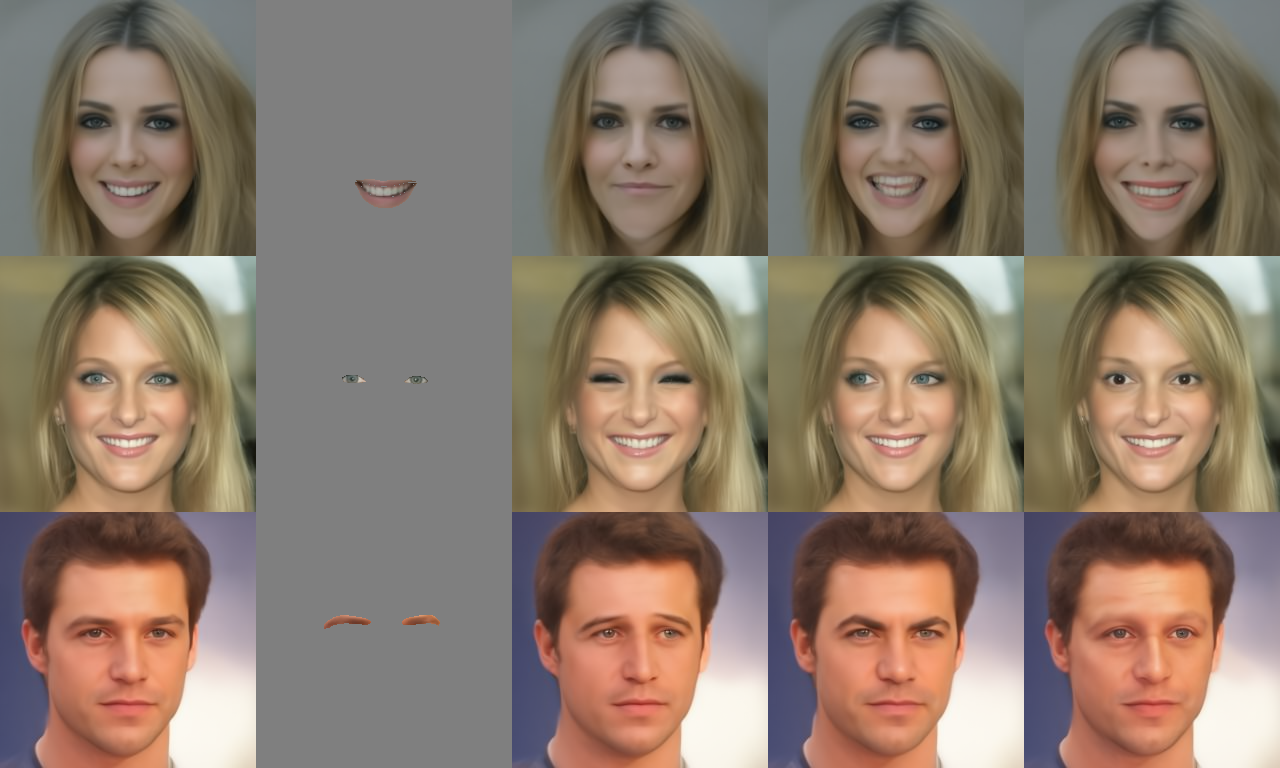

In [ ]:
import torch
import itertools

from semanticdiffusion import load_model, Q
from editing.direction_plotter import DirectionPlotter
from editing.jacobian import PowerItterationMethod
from models.segmentation import SegmentationNetwork
from utils import image_grid, tensor_to_pil


def edit(q, mask, svecs, svals, svec_idx, t_idx, scale):


    n = dp.get_direction(svecs, svals,
                         svec_idx = svec_idx, t_idx = t_idx,
                         global_at_idx = True)

    q_edit = sd.apply_direction(q.copy(), n, scale = scale)
    img = q_edit.x0
    return img

torch.manual_seed(42)

sd = load_model("pixel", device = "cuda",
                h_space = "after",
                num_inference_steps = 10)

power_iter = PowerItterationMethod(sd)
dp = DirectionPlotter(sd)

seg = SegmentationNetwork()


# Edit eyes
q = sd.sample(seed = 596342, etas = 1)
mask = (seg.get_mask(q, "l_eye") + seg.get_mask(q, "r_eye")).clamp(0,1).detach()
svals, svecs = power_iter.load_power_dirs(q, mask = mask)

edits = [(0,2,-50), (0,8,50), (1,4,-50)]
imgs = [q.x0, q.x0*mask] + [edit(q, mask, svecs, svals, *e) for e in edits]
img_eyes = image_grid(imgs)


# Edit eyebrows
q = sd.sample(seed = 731100, etas = 1)
mask = (seg.get_mask(q, "r_brow") + seg.get_mask(q, "l_brow")).clamp(0,1).detach()
svals, svecs = power_iter.load_power_dirs(q, mask = mask)

edits = [(0,6,75), (1,6,75), (0,2,60)]
imgs = [q.x0, q.x0*mask] + [edit(q, mask, svecs, svals, *e) for e in edits]
img_brows = image_grid(imgs)

# Edit Mouth
q = sd.sample(seed = 406599, etas = 1)
mask = seg.get_mask(q, "mouth").detach()
svals, svecs = power_iter.load_power_dirs(q, mask = mask)

edits = [(0,4,50), (0,4,-50), (1,8,-100)]
imgs = [q.x0, q.x0*mask] + [edit(q, mask, svecs, svals, *e) for e in edits]
img_mouth = image_grid(imgs)

grid = image_grid([img_mouth,img_eyes,img_brows], rows = 3, cols = 1)
grid.save("docs/resources/jacobian.png")
grid